# Marketing Campaign Study
The following notebook contains a synthetic toy example of a marketing campaign to show the efficacy of treatment effect estimation.

In [44]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, minmax_scale

plt.style.use("seaborn")
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["figure.facecolor"] = "1"
plt.rcParams["grid.color"] = "black"
plt.rcParams["grid.linestyle"] = ":"
plt.rcParams["grid.linewidth"] = 0.5
plt.rcParams["savefig.dpi"] = 300
plt.rcParams["figure.figsize"] = (10,10)

sns.set_style("whitegrid")
sns.set_context("poster")


NUM_BINS = 200
CYAN = "#4ECDC4"
BLUE = "#59D2FE"
RED = "#FF6B6B"
YELLOW = "#FAA916"
GREY = "#4A6670"

# Cleaning Data - Run Once
Before we can use the banking dataset we clean and prepare the data. That is, we transform categorical features to one-hot encoding and then remove everything we don't use for the sake of simplicity. 
The preprocessing functions are taken from [Kaggle](https://www.kaggle.com/aleksandradeis/bank-marketing-analysis).

In [56]:
def get_dummy_from_bool(row, column_name):
    """Returns 0 if value in column_name is no, returns 1 if value in
    column_name is yes"""
    return 1 if row[column_name] == "yes" else 0


def get_correct_values(row, column_name, threshold, df):
    """ Returns mean value if value in column_name is above threshold"""
    if row[column_name] <= threshold:
        return row[column_name]
    else:
        mean = df[df[column_name] <= threshold][column_name].mean()
        return mean


def clean_data(df):
    """
    INPUT
    df - pandas dataframe containing bank marketing campaign dataset

    OUTPUT
    df - cleaned dataset:
    1. columns with 'yes' and 'no' values are converted into boolean variables;
    2. categorical columns are converted into dummy variables;
    3. drop irrelevant columns.
    4. impute incorrect values
    """

    cleaned_df = df.copy()

    # convert columns containing 'yes' and 'no' values to boolean variables
    # and drop original columns
    bool_columns = ["default", "housing", "loan", "y"]
    for bool_col in bool_columns:
        cleaned_df[bool_col + "_bool"] = df.apply(
            lambda row: get_dummy_from_bool(row, bool_col), axis=1
        )

    cleaned_df = cleaned_df.drop(columns=bool_columns)

    # convert categorical columns to dummies
    cat_columns = ["job", "marital", "education", "contact", "month", "poutcome"]

    for col in cat_columns:
        cleaned_df = pd.concat(
            [
                cleaned_df.drop(col, axis=1),
                pd.get_dummies(
                    cleaned_df[col],
                    prefix=col,
                    prefix_sep="_",
                    drop_first=True,
                    dummy_na=False,
                ),
            ],
            axis=1,
        )

    # drop irrelevant columns
    cleaned_df = cleaned_df.drop(columns=["pdays"])

    # impute incorrect values and drop original columns
    cleaned_df["campaign_cleaned"] = df.apply(
        lambda row: get_correct_values(row, "campaign", 34, cleaned_df), axis=1
    )
    cleaned_df["previous_cleaned"] = df.apply(
        lambda row: get_correct_values(row, "previous", 34, cleaned_df), axis=1
    )

    cleaned_df = cleaned_df.drop(columns=["campaign", "previous"])

    return cleaned_df

# Clean data and write to clean file 
del_col = ['y_bool', 'default_bool', 'loan_bool', 'housing_bool', 'day','job_housemaid', 'job_retired', 'job_self-employed', 'job_student', 'job_technician', 'job_unknown', 'marital_single', 'contact_telephone']

data = pd.read_csv("../datasets/banking/bank.csv", sep=';')
cleaned_data = clean_data(data)
data = cleaned_data.iloc[:, :25].drop(columns=del_col)
data.to_csv("../datasets/banking/clean.csv")

# Import cleaned data 
We've preprocessed the dataset. We: 1) transform boolean features into true booleans, 2) transform categorical features into indicators, 3) drop irrelevant features and 4) imputed missing or incorrect values


In [57]:
data = pd.read_csv("../datasets/banking/clean.csv").drop(columns=['Unnamed: 0'])
data.columns

Index(['age', 'balance', 'duration', 'job_blue-collar', 'job_entrepreneur',
       'job_management', 'job_services', 'job_unemployed', 'marital_married',
       'education_secondary', 'education_tertiary', 'education_unknown'],
      dtype='object')

In [58]:
data.head()

,age,balance,duration,job_blue-collar,job_entrepreneur,job_management,job_services,job_unemployed,marital_married,education_secondary,education_tertiary,education_unknown
0,58,2143,261,0,0,1,0,0,1,0,1,0
1,44,29,151,0,0,0,0,0,0,1,0,0
2,33,2,76,0,1,0,0,0,1,1,0,0
3,47,1506,92,1,0,0,0,0,1,0,0,1
4,33,1,198,0,0,0,0,0,0,0,0,1


# Define synthetic DGP 
We define the synthetic outcomes and treatment assignment for a marketing campaign that was launched before. Since we're not able to perform a random control trial (RCT), we only have this data to do our analysis of treatment effects on. We want to use it in order to find out, which customers to target.

In [59]:
# put features into single variables for convenient naming 
age = data["age"].values
balance = data["balance"].values
duration = data["duration"].values
manager = data["job_management"].values
edu_sec = data["education_secondary"].values
edu_ter = data["education_tertiary"].values
married = data["marital_married"].values

X = data.values

# Scale balance to make it usable as a features without getting massive outliers 
scaled_balance = minmax_scale(balance.reshape(-1, 1), feature_range=(-100, 10000))[:, 0]
standard_age = StandardScaler().fit_transform(age.reshape(-1, 1))[:, 0]

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# Define control outcome 
y_0 = ((85 - age) ** 2)/5 + manager * 150 + scaled_balance

# Define \tau, the treatment effect
ite = (
    (85 - age) * 10
    + edu_sec * 200
    + edu_ter * 100
    - married * 150
    + np.random.normal(0, 10)
)

y_1 = y_0 + ite

# Generate observational data based on the hunch of the marketing department
idx = np.argsort(scaled_balance)[-10000:]
t = np.zeros(len(y_1))
t[idx] = 1

y = (y_1 * t) + y_0 * (1 - t)
y_cf = y_1 * (1 - t) + y_0 * t

## Understanding the Distribution
We now look at some plots describing the distribution. First the distribution of treatment effects.

In [60]:
np.unique(t, return_counts=True)

(array([0., 1.]), array([35211, 10000]))

Text(0.5,1,'Distribution of treatment effects')

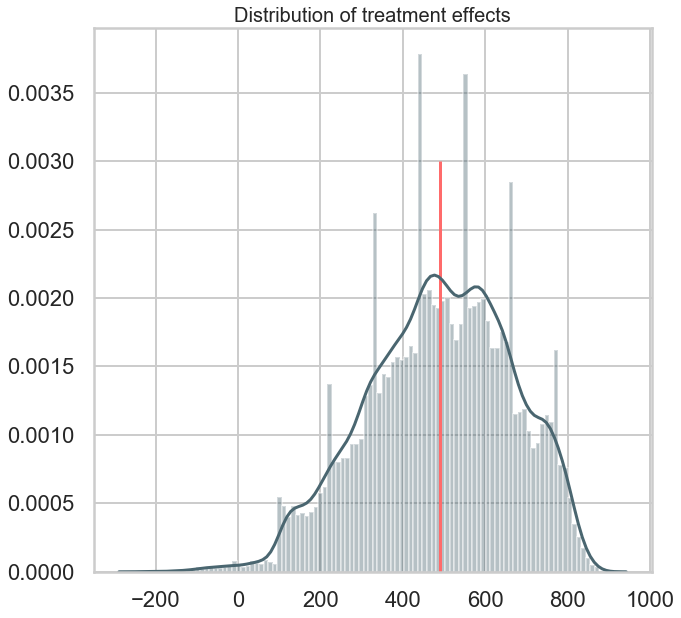

In [61]:
sns.distplot(ite, color=GREY, bins=100)
plt.vlines(np.mean(ite), ymin=0, ymax=0.003, color=RED)
plt.title('Distribution of treatment effects', size=20)


Next, we look at the influence of the `balance` feature on the control outcome $y_0$ as well as the treatment effect $\tau$. What we see is that the balance has a direct effect on the outcome in general, but no measurable effect on or correlation with the treatment effect. This will be an important insight for later on. 

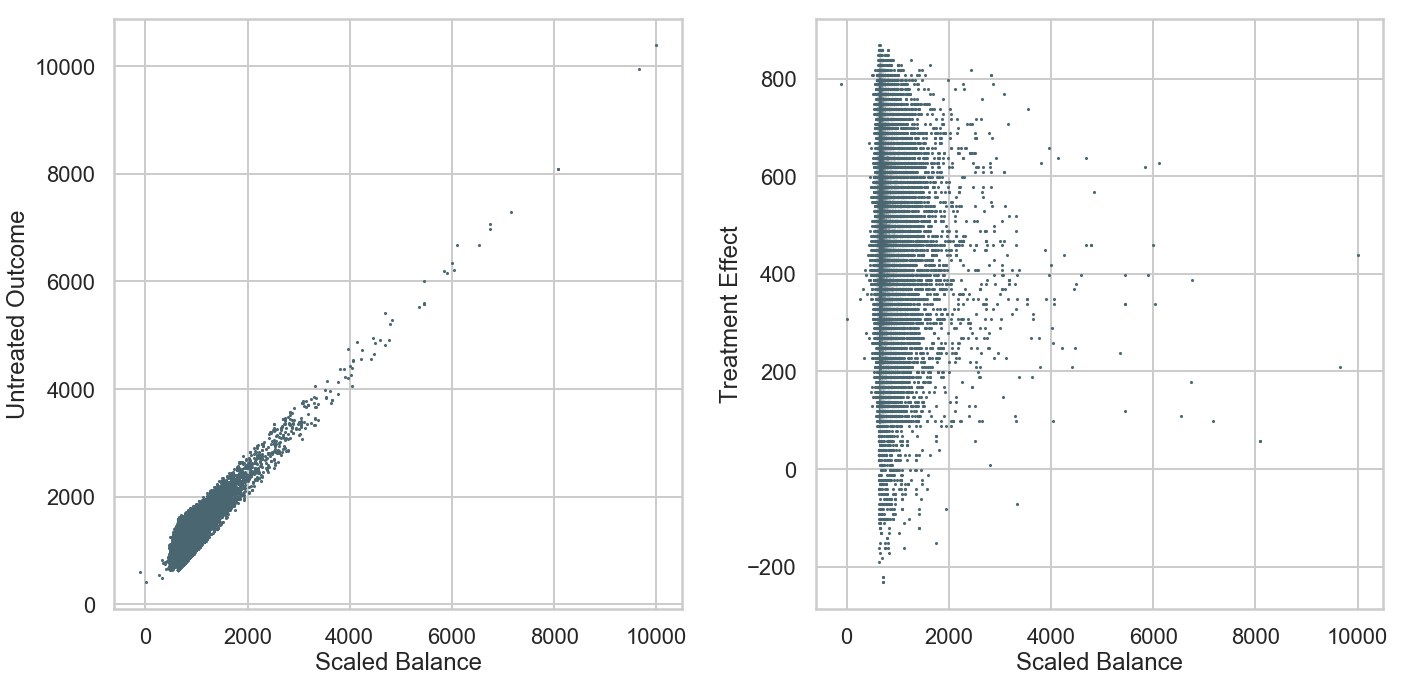

In [33]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


ax1.scatter(scaled_balance, y_0, s=5, marker=".", color=GREY)
ax1.set_xlabel('Scaled Balance')
ax1.set_ylabel('Untreated Outcome')

ax2.scatter(scaled_balance, ite, s=5, marker=".", color=GREY)
ax2.set_xlabel('Scaled Balance')
ax2.set_ylabel('Treatment Effect')

plt.tight_layout()

We do the same analysis for the `age` feature. Age, other than balance, has only a slight influence on the outcome in general, but is directly related to the treatment effect. Looking at the definition of the DGP, this is obvious.

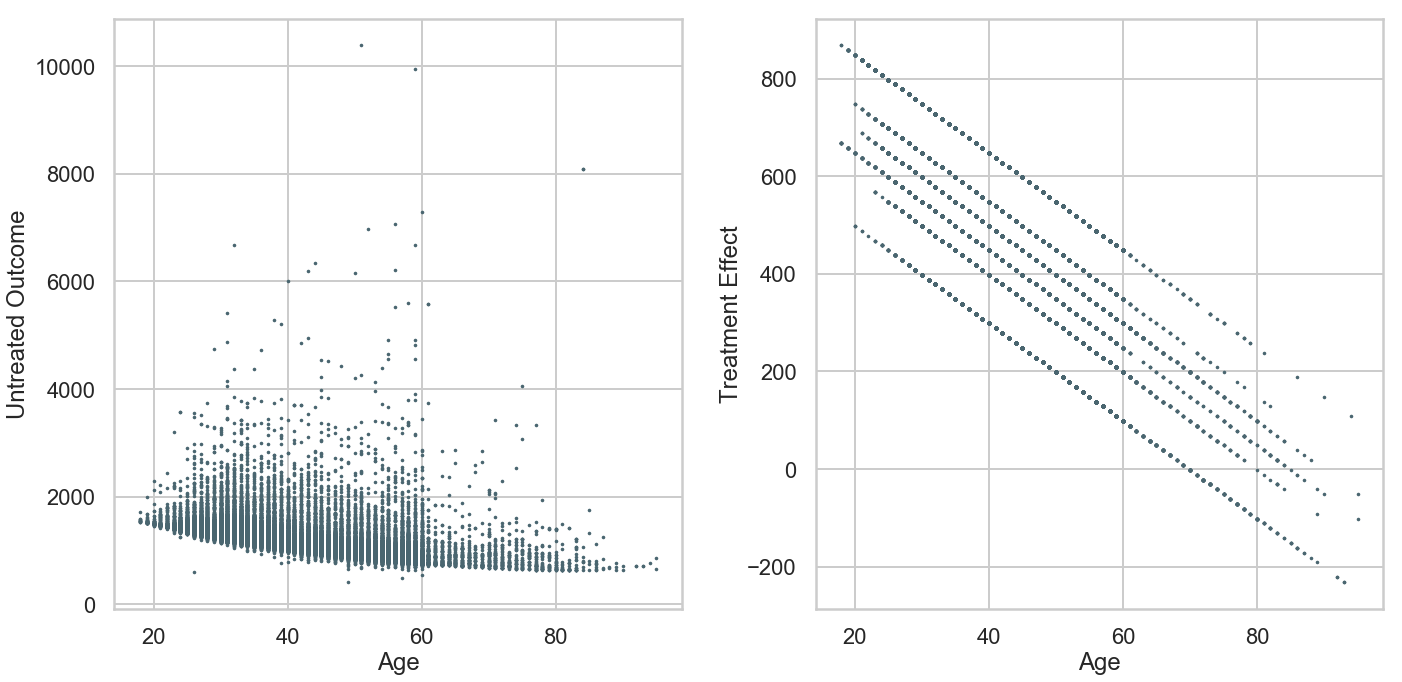

In [34]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))


ax1.scatter(age, y_0, s=10, marker=".", color=GREY)
ax1.set_xlabel('Age')
ax1.set_ylabel('Untreated Outcome')

ax2.scatter(age, ite, s=10, marker=".", color=GREY)
ax2.set_xlabel('Age')
ax2.set_ylabel('Treatment Effect')

plt.tight_layout()

# Comparing different Strategies 
We now compare different strategies for the new marketing campaign with which we can target up to 2000 people from our customer base. The ideas behind these approaches are explained in more detailed in the blog post.

## 1. Target young users (like in the previous study) 
2000 youngest users. 

In [39]:
idx = np.argsort(age)[:2000]
money_earned = np.sum(ite[idx]) 

In [1]:
round(money_earned, 2)

NameError: name 'money_earned' is not defined

## 2. Target users with high balance

In [62]:
idx = np.argsort(balance)[-2000:]
money_earned = np.sum(ite[idx]) 
round(money_earned, 2)

886450.15

## 3. Target users based on T-Learner estimate
We use a T-Learner to estimate the treatment effects based on the observational data from the previous campaign

In [63]:
from justcause.learners import TLearner, XLearner, RLearner, CausalForest
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

learner = TLearner(learner=LinearRegression())
learner.fit(X, t, y)
ite_pred = learner.predict_ite(X, t, y, replace_factuals=True)

In [64]:
idx = np.argsort(ite_pred)[-2000:]
money_earned = np.sum(ite[idx]) 
round(money_earned, 2)

1597590.15

### Benefit of T-Learner
When we compare the estimated treatment effect with the true treatment effect for all instances in the plot below, we see that the T-Learner almost perfectly estimates the effects. That is to say the estimates are very close to the true values. Thus, we can say that the T-Learner manages to clean the the effects. 

Text(0.5,1,'cleaning effect of T-Learner')

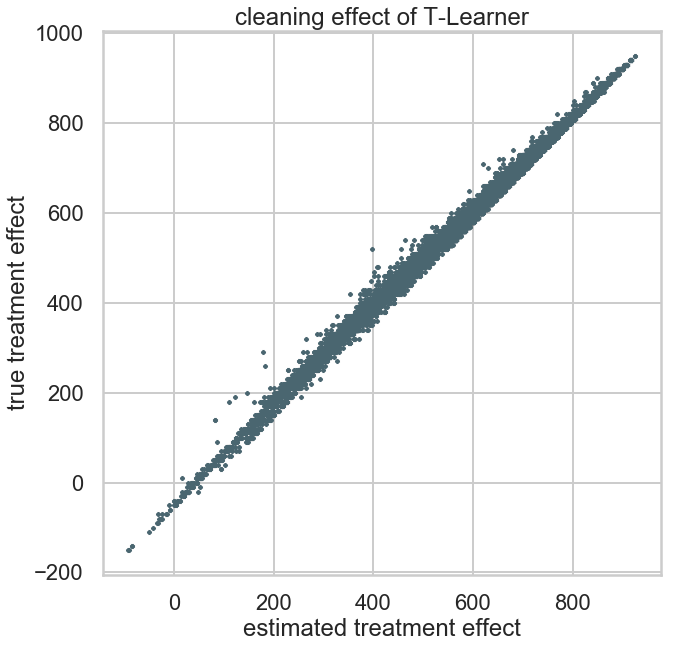

In [18]:
plt.scatter(ite_pred, ite, s=10, marker="x", color=GREY)
plt.xlabel('estimated treatment effect')
plt.ylabel('true treatment effect')
plt.title('cleaning effect of T-Learner')

## 4. Target users based on unobserved data
This represent the best possible outcome, which is achieved by directly targeting the users with the highest true treatment effect. Note that this quantity (their true treatment effect) is not available. 

In [19]:
idx = np.argsort(ite)[-2000:]
money_earned = np.sum(ite[idx]) 
round(money_earned, 2)

1744148.14

# Uplift Plot 
We see that among the four comparisons above, using a dedicated treatment effect learner fares best. We do not go into detail with comparing different learners as this would exceed the scope of this article. However, there's another article coming up with an in-depth introduction to some basic learners and a presentation of JustCause. 

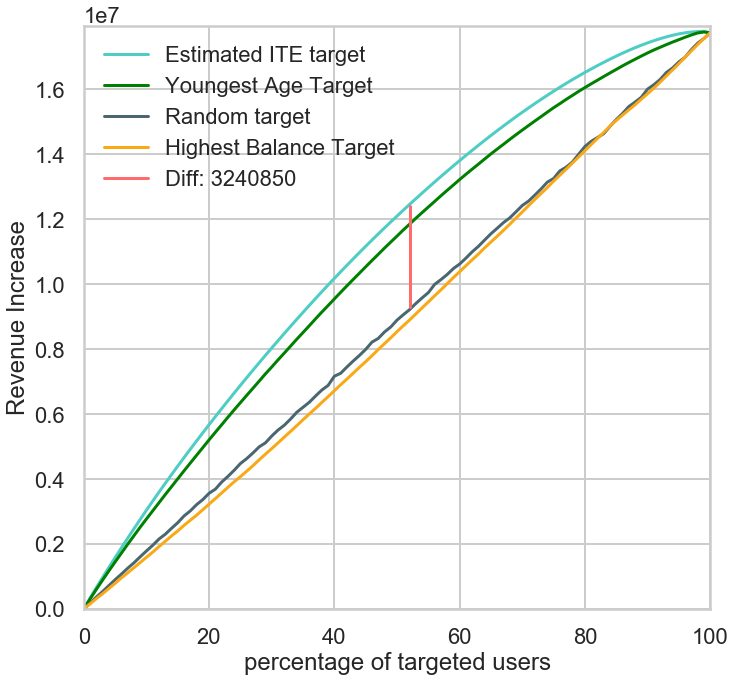

In [209]:
idxs_marketing = np.flip(np.argsort(scaled_balance))
idxs_age = np.argsort(age) # youngest first
idxs_ite = np.flip(np.argsort(ite_pred))
ite_plot = []
marketing_plot = []
random_plot = []
age_plot=[]


for i in range(101):
    num_treated = int(len(t)*(i/100))
    idxs_marketing_sub = idxs_marketing[0:num_treated] # use only as many as before
    idxs_age_sub = idxs_age[0:num_treated] # use only as many as before
    idxs_ite_sub = idxs_ite[0:num_treated] # use only as many as before
    idxs_random = np.random.choice(len(t), num_treated)
    ite_plot.append(np.sum(ite[idxs_ite_sub]))
    marketing_plot.append(np.sum(ite[idxs_marketing_sub]))
    random_plot.append(np.sum(ite[idxs_random]))
    age_plot.append(np.sum(ite[idxs_age_sub]))

max_idx = np.argmax(np.array(ite_plot) - np.array(random_plot))
sns.lineplot(x=np.arange(101), y=np.array(ite_plot), color=CYAN, label='Estimated ITE target')
sns.lineplot(x=np.arange(101), y=np.array(age_plot), color="green", label='Youngest Age Target')
sns.lineplot(x=np.arange(101), y=np.array(random_plot), color=GREY, label='Random target')
sns.lineplot(x=np.arange(101), y=np.array(marketing_plot), color=YELLOW, label='Highest Balance Target')
plt.xlabel('percentage of targeted users')
plt.ylabel('Revenue Increase')
y_min = random_plot[max_idx]/np.max(ite_plot)
y_max = ite_plot[max_idx]/np.max(ite_plot) - 0.01 # slight manual correction
plt.axvline(x=max_idx,ymin=y_min, ymax=y_max, color=RED, label='Diff: '+ str(int(ite_plot[max_idx] - random_plot[max_idx])))
plt.legend()
plt.xlim(0, 100)
plt.ylim(0, np.max(ite_plot)*1.01)
plt.show()